@author: Valentin Larrieu

<center>Geoloc IoT</center> <br>


The goal of this project is to use data projectovided by some iot equipmentto guess the real position of the equipment (without using GPS). The goal is to have to lowest range of detection possible

## Import

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import time

## Metrics functions

In [2]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [3]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

## Load data

In [4]:
# load train and test data
df_mess_train = pd.read_csv('Files/mess_train_list.csv') # train set
df_mess_test = pd.read_csv('Files/mess_test_list.csv') # test set
pos_train = pd.read_csv('Files/pos_train_list.csv') # position associated to train set

In [5]:
pos_train.head(5)

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
df_mess_train.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109


In [7]:
print(df_mess_train.dtypes, end="\n\n")
print(pos_train.dtypes)

messid      object
bsid         int64
did        float64
nseq       float64
rssi       float64
time_ux    float64
bs_lat     float64
bs_lng     float64
dtype: object

lat    float64
lng    float64
dtype: object


## Data Exploration

### Distance device from base station

In [8]:
def vinc(row):
    return (vincenty(row[['bs_lat', 'bs_lng']], row[['lat', 'lng']])).km

In [9]:
def calc_df_dist(df_mess_train):
    df_dist = df_mess_train.copy().drop(columns="nseq")
    df_dist[['lat', 'lng']] = pos_train
    df_dist['dist'] = df_dist.apply (lambda row: vinc(row),axis=1)
    return df_dist
df_dist = calc_df_dist(df_mess_train)
df_dist.head(10)

,messid,bsid,did,rssi,time_ux,bs_lat,bs_lng,lat,lng,dist
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,-121.500000,1.463546e+12,39.617794,-104.954917,39.606690,-104.958490,1.270478
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,-125.000000,1.463546e+12,39.677251,-104.952721,39.606690,-104.958490,7.849924
2,573bf3533e952e19126b256a,2605,473335.0,-134.000000,1.463547e+12,39.612745,-105.008827,39.637741,-104.958554,5.131578
3,573c0cd0f0fe6e735a699b93,2610,473953.0,-132.000000,1.463553e+12,39.797969,-105.073460,39.730417,-104.968940,11.681759
4,573c0cd0f0fe6e735a699b93,3574,473953.0,-120.000000,1.463553e+12,39.723151,-104.956216,39.730417,-104.968940,1.356862
5,573c0cd0f0fe6e735a699b93,8474,473953.0,-100.000000,1.463553e+12,39.732045,-104.973651,39.730417,-104.968940,0.442417
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,-123.333333,1.463555e+12,39.704887,-105.016392,39.693102,-105.006995,1.536772
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,-129.666667,1.463555e+12,39.612745,-105.008827,39.693102,-105.006995,8.923302
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,-123.666667,1.463555e+12,39.654682,-105.043685,39.693102,-105.006995,5.301508
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,-133.000000,1.463555e+12,39.495225,-105.053109,39.693102,-105.006995,22.323917


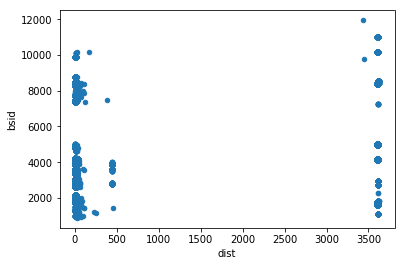

In [10]:
df_dist.plot.scatter(x = "dist", y="bsid")
plt.show()

<center>Here, we observe messages for which a bsid (a station) received the message at 500km or 3500km : <strong> these are outliers.</strong> <br> <br>
<strong>In the following, we will try to analyze the stations in question and determine if they are defective</strong></center>

### Find defective stations

In [11]:
distMax = 50
count = df_dist.groupby('bsid')['dist'].count()
sup = df_dist.groupby('bsid')['dist'].apply(lambda x: (x > distMax).sum())

In [12]:
# Comparison between the number of messages received by a station and the number of messages whose calculated distance is out of range
comparaison = pd.DataFrame([count, sup], index = ["count", "nbSup"]).T
comparaison['bsid'] = comparaison.index
comparaison[["count", "nbSup"]].head(10)

,count,nbSup
bsid,,
879,1,0
911,1,0
921,1,0
944,3,1
980,8,1
1012,85,0
1086,67,0
1092,32,32
1120,1,0


In [13]:
# List of'bsid' whose number of outliers represents more than X% of the total number of messages received
# --> These stations are considered defective and must be deleted

ratioMax = 0.1
bsidToShift = comparaison[comparaison['nbSup'] >= ratioMax * comparaison['count']]['bsid'].values
len(bsidToShift)
len(df_dist['bsid'].unique())

251

## Data Cleaning

In [14]:
df = df_mess_train.copy().drop(columns=["messid","did","nseq","rssi","time_ux"])
df[['lat', 'lng']] = pos_train
df_toShift = df[df['bsid'].isin(bsidToShift)]
df_toShift.head()

,bsid,bs_lat,bs_lng,lat,lng
5106,8355,64.3,-68.5,39.778694,-104.977050
5118,8355,64.3,-68.5,39.783396,-104.999821
5179,8355,64.3,-68.5,39.803407,-105.019300
5216,8355,64.3,-68.5,39.803738,-105.018997
5416,8355,64.3,-68.5,39.803101,-105.023292


In [15]:
df_toShift_grouped = df_toShift.groupby('bsid')
newCoord_lat = {}
newCoord_lng = {}

for key, elmt in df_toShift_grouped:
    newCoord_lat[key] = elmt['lat'].values.mean()
    newCoord_lng[key] = elmt['lng'].values.mean()

In [16]:
def process_row(row):
    row_copy = row.copy()
    if row['bsid'] in bsidToShift :
        row_copy['bs_lat'] = newCoord_lat[row['bsid']]
        row_copy['bs_lng'] = newCoord_lng[row['bsid']]
    return row_copy

df_mess_train_v2 = df_mess_train.copy()
df_mess_train_v2 = df_mess_train_v2.apply(process_row, axis=1)

In [17]:
df_mess_train_v2.head(10)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.500000,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.000000,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.000000,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.000000,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.000000,1.463553e+12,39.723151,-104.956216
5,573c0cd0f0fe6e735a699b93,8474,473953.0,2.0,-100.000000,1.463553e+12,39.732045,-104.973651
6,573c1272f0fe6e735a6cb8bd,1859,476512.0,1.0,-123.333333,1.463555e+12,39.704887,-105.016392
7,573c1272f0fe6e735a6cb8bd,2605,476512.0,1.0,-129.666667,1.463555e+12,39.612745,-105.008827
8,573c1272f0fe6e735a6cb8bd,3025,476512.0,1.0,-123.666667,1.463555e+12,39.654682,-105.043685
9,573c1272f0fe6e735a6cb8bd,8082,476512.0,1.0,-133.000000,1.463555e+12,39.495225,-105.053109


In [18]:
df_dist_v2 = calc_df_dist(df_mess_train_v2)

Text(0.5, 1.0, 'Distance from device for each station')

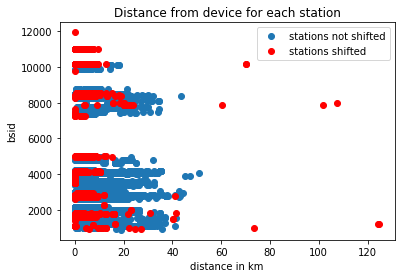

In [19]:
dist_bs_shifted = df_dist_v2[df['bsid'].isin(bsidToShift)]['dist']
bsid_bs_shifted = df_dist_v2[df['bsid'].isin(bsidToShift)]['bsid']
dist_bs = df_dist_v2[~df['bsid'].isin(bsidToShift)]['dist']
bsid_bs = df_dist_v2[~df['bsid'].isin(bsidToShift)]['bsid']
plt.plot(dist_bs, bsid_bs, 'o', label="stations not shifted")
plt.plot(dist_bs_shifted, bsid_bs_shifted, 'ro', label="stations shifted")
plt.legend()
plt.xlabel("distance in km")
plt.ylabel("bsid")
plt.title("Distance from device for each station")

We note that there is almost no more station with abnormal distances from devices

## First feature Engineering

In [20]:
# Matrix de 0 ou lat (mess recu par la bsid )
def lat_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess
    indexes = []

    for key, elmt in df_mess_bs_group:
        indexes.append(key)
        df_feat.loc[idx,elmt['bsid']] = elmt["bs_lat"].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, indexes # add id value of each message for the correspondance to message 

# Maxtrice de 0 ou lng (mess recu par la bsid 
def lng_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,elmt['bsid']] = elmt["bs_lng"].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  # Mactrix de 0 ou rssi (mess recu par la bsid )

def rssi_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,elmt['bsid']] = - elmt['rssi'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

def nseq_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,elmt['bsid']] = elmt['nseq'].values
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

# Maxtrice de 0 ou 1 (mess recu par la bsid )
def did_mat_const(df_mess_train, listOfBs):
    df_mess_bs_group = df_mess_train.groupby(['messid'], as_index=False) # group data by message (messid)
    nb_mess = len(np.unique(df_mess_train['messid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,1)), columns = ['did']) # feature matrix
    idx = 0
    id_list = [0] * nb_mess

    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx,'did'] = elmt['did'].mean()
        id_list[idx] = key
        idx = idx + 1
    
    return df_feat, id_list # add id value of each message for the correspondance to message  

In [21]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message
df_feat_lat, id_list = lat_mat_const(df_mess_train, listOfBs)
indexes = df_feat_lat.columns.values
df_feat_lng, id_list = lng_mat_const(df_mess_train, listOfBs)
df_rssi, id_list = rssi_mat_const(df_mess_train, listOfBs)
df_nseq, id_list = nseq_mat_const(df_mess_train, listOfBs)
df_did, id_list = did_mat_const(df_mess_train, listOfBs)

In [22]:
def features_lat(df_feat_lat, df_rssi, df_nseq, df_did, indexes):
    df = df_feat_lat.copy()
    indx = indexes
    for i in range(len(indx)) :
        df['rssi'+str(indx[i])] = df_rssi[indx[i]]
        df['nseq'+str(indx[i])] = df_nseq[indx[i]]
    df['did'] = df_did['did']
    return df, indexes

def features_lng(df_feat_lng, df_rssi, df_nseq, df_did, indexes):
    df = df_feat_lng.copy()
    indx = indexes
    for i in range(len(indx)) :
        df['rssi'+str(indx[i])] = df_rssi[indx[i]]
        df['nseq'+str(indx[i])] = df_nseq[indx[i]]  
    df['did'] = df_did['did']
    return df, indexes

### Construct lat and lng features

In [23]:
# LAT
df_feat_lat, id_list_train = features_lat(df_feat_lat, df_rssi, df_nseq, df_did, indexes)
df_feat_lat.reset_index()
df_feat_lat.shape
df_feat_lat.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,nseq10151,rssi10162,nseq10162,rssi10999,nseq10999,rssi11007,nseq11007,rssi11951,nseq11951,did
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473953.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476512.0
4,0.0,0.0,0.0,0.0,0.0,0.0,39.973995,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476286.0


In [24]:
# LNG
df_feat_lng, id_list_train = features_lng(df_feat_lng, df_rssi, df_nseq, df_did, indexes)
df_feat_lng.reset_index()
df_feat_lng.shape
df_feat_lng.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,nseq10151,rssi10162,nseq10162,rssi10999,nseq10999,rssi11007,nseq11007,rssi11951,nseq11951,did
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473335.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473953.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476512.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-104.891717,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,476286.0


In [25]:
# ground truth construction
def ground_truth_train(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['messid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['messid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [26]:
ground_truth_lat, ground_truth_lng = ground_truth_train(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

## Train/test split

In [27]:
from sklearn.model_selection import train_test_split

def trainTestSplit(X, Y, testSize, seed):
    
    df = X.copy()
    df['Y'] = Y
    
    did = df['did'].unique()
    did_train, did_test = train_test_split(did, test_size = testSize, random_state = seed)
    
    Y_train, Y_test = df[df['did'].isin(did_train)]['Y'], df[df['did'].isin(did_test)]['Y']
    df = df.drop('Y', axis = 1)
    
    X_train, X_test = df[df['did'].isin(did_train)], df[df['did'].isin(did_test)]
    X_train, X_test = X_train.drop('did', axis = 1), X_test.drop('did', axis = 1)
    
    return X_train, X_test, Y_train, Y_test

In [28]:
X_train_lat, X_test_lat, y_train_lat, y_test_lat = trainTestSplit(df_feat_lat, ground_truth_lat, \
                                                         testSize = 0.1, seed = 42)
X_train_lng, X_test_lng, y_train_lng, y_test_lng = trainTestSplit(df_feat_lng, ground_truth_lng, \
                                                         testSize = 0.1, seed = 42)

## Modelisation

In [29]:
def regressor_and_predict(X_train_lat, X_test_lat, y_train_lat, X_train_lng, X_test_lng, y_train_lng):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn import linear_model
    # lat
    reg_lat = linear_model.LinearRegression()

    reg_lat.fit(X_train_lat, y_train_lat)
    y_pred_lat = reg_lat.predict(X_test_lat) 
    
    #lng
    reg_lng = linear_model.LinearRegression()

    reg_lng.fit(X_train_lng, y_train_lng)
    y_pred_lng = reg_lng.predict(X_test_lng) 
    
    return y_pred_lat, y_pred_lng

In [30]:
def rf_and_predict(X_train_lat, X_test_lat, y_train_lat, X_train_lng, X_test_lng, y_train_lng):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    from sklearn.ensemble import RandomForestRegressor
    # lat
    rf_lat = RandomForestRegressor(n_estimators = 100, random_state = 1)

    rf_lat.fit(X_train_lat, y_train_lat)
    y_pred_lat = rf_lat.predict(X_test_lat)
    
    #lng
    rf_lng = RandomForestRegressor(n_estimators = 100, random_state = 1)

    rf_lng.fit(X_train_lng, y_train_lng)
    y_pred_lng = rf_lng.predict(X_test_lng)
    
    return y_pred_lat, y_pred_lng

## Predictions and score

### Linear Regression model

In [31]:
# Make regressor and prediction using the train set
y_pred_lat, y_pred_lng = regressor_and_predict(X_train_lat, X_test_lat, y_train_lat, \
                                        X_train_lng, X_test_lng, y_train_lng)

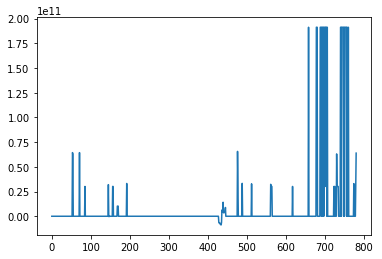

In [32]:
plt.plot(y_pred_lat)

Prediction are not good enough to compute the distances because a lot of value are in the range [-90,90]

### Random Forest Regression Model

In [33]:
# Make regressor and prediction using the train set
y_pred_lat, y_pred_lng = rf_and_predict(X_train_lat, X_test_lat, y_train_lat, \
                                        X_train_lng, X_test_lng, y_train_lng)
err_vec = Eval_geoloc(y_test_lat, y_test_lng, y_pred_lat, y_pred_lng)
print("RandomForestRegressor Score 80 percentile =", np.percentile(err_vec, 80))

RandomForestRegressor Score 80 percentile = 3802.661614248619


## Cross validation

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

In [35]:
def split(X, Y, nbOfSplit, seed):
    scaler = StandardScaler()
    np.random.seed(seed)
    
    df = X.copy()
    df['Y'] = Y
    
    
    did = df['did'].unique()
    np.random.shuffle(did)
    did_splits= np.array_split(did, nbOfSplit)
    
    df.reset_index(drop=True, inplace = True)

    splits = []
    for split in did_splits:
        Y = df[df['did'].isin(split)]['Y']

        X = df[df['did'].isin(split)]
        X = X.drop(['did', 'Y'], axis = 1)
        
        indexToLeave = X.index.values
        others = np.array( list(set(df.index.values) - set(indexToLeave)) )
        
        splits.append((others, indexToLeave))
        
    Y = df['Y']
    X = df.drop(['Y','did'], axis = 1)
    
    X = pd.DataFrame(scaler.fit_transform(X,Y))
    
    return X, Y, splits

In [36]:
def CrossValPredict_RF(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lng):
    from sklearn.ensemble import RandomForestRegressor

    rf_lat = RandomForestRegressor(n_estimators = 100, random_state = 1)
    y_pred_lat = cross_val_predict(rf_lat, X_lat, Y_lat, cv = splits_lat, n_jobs = -1)


    rf_lng = RandomForestRegressor(n_estimators = 100, random_state = 1)
    y_pred_lng = cross_val_predict(rf_lng, X_lng, Y_lng, cv = splits_lng, n_jobs = -1)
    
    return y_pred_lat, y_pred_lng

In [37]:
def CrossValPredict_ET(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lng) :    
    from sklearn.ensemble import ExtraTreesRegressor

    rf_lat = ExtraTreesRegressor(n_estimators = 100, random_state = 1)
    y_pred_lat = cross_val_predict(rf_lat, X_lat, Y_lat, cv = splits_lat, n_jobs = -1)


    rf_lng = ExtraTreesRegressor(n_estimators = 100, random_state = 1)
    y_pred_lng = cross_val_predict(rf_lng, X_lng, Y_lng, cv = splits_lng, n_jobs = -1)
    
    return y_pred_lat, y_pred_lng

In [38]:
def CrossValPredict_GB(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lng):
    from sklearn.ensemble import GradientBoostingRegressor

    rf_lat = GradientBoostingRegressor(n_estimators = 500, random_state = 1)
    y_pred_lat = cross_val_predict(rf_lat, X_lat, Y_lat, cv = splits_lat, n_jobs = -1)


    rf_lng = GradientBoostingRegressor(n_estimators = 500, random_state = 1)
    y_pred_lng = cross_val_predict(rf_lng, X_lng, Y_lng, cv = splits_lng, n_jobs = -1)
    
    return y_pred_lat, y_pred_lng

In [39]:
X_lat, Y_lat, splits_lat = split(df_feat_lat, ground_truth_lat, nbOfSplit=10, seed = 1)
X_lng, Y_lng, splits_lng = split(df_feat_lng, ground_truth_lng, nbOfSplit=10, seed = 1)

## Predictions and score

In [40]:
y_pred_lat, y_pred_lng = CrossValPredict_RF(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lat)
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)

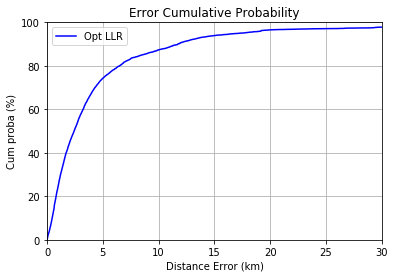

In [41]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.show()

In [42]:
print("RandomForestRegressor Score 80 percentile =", np.percentile(err_vec, 80))

RandomForestRegressor Score 80 percentile = 6494.610880919496


In [43]:
y_pred_lat, y_pred_lng = CrossValPredict_ET(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lat)
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
print("CrossValPredict_ET Score 80 percentile =", np.percentile(err_vec, 80))

y_pred_lat, y_pred_lng = CrossValPredict_GB(X_lat, Y_lat, X_lng, Y_lng, splits_lat, splits_lat)
err_vec = Eval_geoloc(ground_truth_lat, ground_truth_lng, y_pred_lat, y_pred_lng)
print("GradientBoostingRegressor Score 80 percentile =", np.percentile(err_vec, 80))

CrossValPredict_ET Score 80 percentile = 7442.156908218203
GradientBoostingRegressor Score 80 percentile = 8866.187901132887


# Try new Feature Engineering 

In [44]:
df_mess_train.head(5)

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [45]:
# Feature Matrix construction V2

def feat_mat_const(df_mess, nb_max_base=5):
    list_messid = list(df_mess.drop_duplicates(subset='messid')['messid'])

    #Init map
    map_new_df = {}
    map_new_df['messid'] = list_messid
    for i in range(0,nb_max_base):
        map_new_df['bs_lat' + str(i)] = []
        map_new_df['bs_lng' + str(i)] = []
        map_new_df['nseq' + str(i)] = []
        map_new_df['rssi' + str(i)] = []

    for i in range(0,nb_max_base):
        list_lat = []
        list_lng = []
        list_nseq = []
        list_rssi = []
        for messid in list_messid:
            df_temp = df_mess[df_mess['messid'] == messid].sort_values(by=["time_ux"], ascending=True)
            idx = min(len(df_temp) - 1, i)
            list_lat.append(list(df_temp['bs_lat'])[idx])
            list_lng.append(list(df_temp['bs_lng'])[idx])
            list_nseq.append(list(df_temp['nseq'])[idx])
            list_rssi.append(list(df_temp['rssi'])[idx])
            
        map_new_df['bs_lat' + str(i)] = list_lat
        map_new_df['bs_lng' + str(i)] = list_lng
        map_new_df['nseq' + str(i)] = list_nseq
        map_new_df['rssi' + str(i)] = list_rssi
        
    df_feat_mess = pd.DataFrame(map_new_df)
    df_mess_join = df_mess.copy()
    df_mess_join = df_mess_join.drop(columns=['bsid','nseq','rssi','time_ux','bs_lat','bs_lng'])
    df_feat = df_mess_join.merge(df_feat_mess, on='messid')
    return df_feat

def prepare_mat_train(df_feat):
    df_feat = df_feat.drop(columns='did')
    return df_feat.drop_duplicates(subset=['messid']).drop(columns=['messid'])
    
def prepare_mat_test(df_feat):
    return df_feat.drop(columns=['messid','did'])   

In [46]:
df_feat = feat_mat_const(df_mess_train,  nb_max_base=5)
df_feat.head(5)

,messid,did,bs_lat0,bs_lng0,nseq0,rssi0,bs_lat1,bs_lng1,nseq1,rssi1,...,nseq2,rssi2,bs_lat3,bs_lng3,nseq3,rssi3,bs_lat4,bs_lng4,nseq4,rssi4
0,573bf1d9864fce1a9af8c5c9,473335.0,39.617794,-104.954917,0.5,-121.5,39.677251,-104.952721,2.0,-125.0,...,2.0,-125.0,39.677251,-104.952721,2.0,-125.0,39.677251,-104.952721,2.0,-125.0
1,573bf1d9864fce1a9af8c5c9,473335.0,39.617794,-104.954917,0.5,-121.5,39.677251,-104.952721,2.0,-125.0,...,2.0,-125.0,39.677251,-104.952721,2.0,-125.0,39.677251,-104.952721,2.0,-125.0
2,573bf3533e952e19126b256a,473335.0,39.612745,-105.008827,1.0,-134.0,39.612745,-105.008827,1.0,-134.0,...,1.0,-134.0,39.612745,-105.008827,1.0,-134.0,39.612745,-105.008827,1.0,-134.0
3,573c0cd0f0fe6e735a699b93,473953.0,39.797969,-105.073460,2.0,-132.0,39.723151,-104.956216,1.0,-120.0,...,2.0,-100.0,39.732045,-104.973651,2.0,-100.0,39.732045,-104.973651,2.0,-100.0
4,573c0cd0f0fe6e735a699b93,473953.0,39.797969,-105.073460,2.0,-132.0,39.723151,-104.956216,1.0,-120.0,...,2.0,-100.0,39.732045,-104.973651,2.0,-100.0,39.732045,-104.973651,2.0,-100.0


In [47]:
df_feat_v2 = feat_mat_const(df_mess_train_v2,  nb_max_base=5)
df_feat.head(5)

,messid,did,bs_lat0,bs_lng0,nseq0,rssi0,bs_lat1,bs_lng1,nseq1,rssi1,...,nseq2,rssi2,bs_lat3,bs_lng3,nseq3,rssi3,bs_lat4,bs_lng4,nseq4,rssi4
0,573bf1d9864fce1a9af8c5c9,473335.0,39.617794,-104.954917,0.5,-121.5,39.677251,-104.952721,2.0,-125.0,...,2.0,-125.0,39.677251,-104.952721,2.0,-125.0,39.677251,-104.952721,2.0,-125.0
1,573bf1d9864fce1a9af8c5c9,473335.0,39.617794,-104.954917,0.5,-121.5,39.677251,-104.952721,2.0,-125.0,...,2.0,-125.0,39.677251,-104.952721,2.0,-125.0,39.677251,-104.952721,2.0,-125.0
2,573bf3533e952e19126b256a,473335.0,39.612745,-105.008827,1.0,-134.0,39.612745,-105.008827,1.0,-134.0,...,1.0,-134.0,39.612745,-105.008827,1.0,-134.0,39.612745,-105.008827,1.0,-134.0
3,573c0cd0f0fe6e735a699b93,473953.0,39.797969,-105.073460,2.0,-132.0,39.723151,-104.956216,1.0,-120.0,...,2.0,-100.0,39.732045,-104.973651,2.0,-100.0,39.732045,-104.973651,2.0,-100.0
4,573c0cd0f0fe6e735a699b93,473953.0,39.797969,-105.073460,2.0,-132.0,39.723151,-104.956216,1.0,-120.0,...,2.0,-100.0,39.732045,-104.973651,2.0,-100.0,39.732045,-104.973651,2.0,-100.0


In [48]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    ground_truth_lat = pd.DataFrame({'messid':df_mess_train['messid'],'lat':pos_train['lat']})
    ground_truth_lng = pd.DataFrame({'messid':df_mess_train['messid'],'lng':pos_train['lng']})

    return ground_truth_lat, ground_truth_lng

def prepare_ground_truth_train(ground_truth):
    return ground_truth.drop_duplicates(subset=['messid']).drop(columns=['messid'])
    
def prepare_ground_truth_test(ground_truth):
    return ground_truth.drop(columns=['messid'])

In [49]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
print("shape of ground_truth:", ground_truth_lat.shape)
print("shape of feature matrix:", df_feat.shape)

shape of ground_truth: (39250, 2)
shape of feature matrix: (39250, 22)


# Cross validation 

In [50]:
def get_mask_did(did, np_feat_mat):
    mask = df_feat.where(df_feat['did']==did)['did'].notna()
    return mask

def leaveOneDeviceOut_folds_mask(df_feat):
    list_did = list(df_feat.drop_duplicates('did')['did'])
    #list_folds_index = list(map(get_index_did, list_did, np_feat_mat))
    list_folds_mask = [get_mask_did(did,df_feat) for did in list_did]
    return list_folds_mask  

In [51]:
list_folds_mask = leaveOneDeviceOut_folds_mask(df_feat)
print("Nb folds for leave one device out :",len(list_folds_mask))

Nb folds for leave one device out : 113


In [52]:
from sklearn.linear_model import LinearRegression

def model_fit_lr(X_train, y_lat_train, y_lng_train, X_test, y_lat_test, y_lng_test,\
                 params={}):
        
    regr_lat = LinearRegression()
    regr_lng = LinearRegression()
         
    regr_lat.fit(X_train, y_lat_train)
    regr_lng.fit(X_train, y_lng_train)
    
    return regr_lat, regr_lng

def model_predict(X, model_lat, model_lng):
    y_pred_lat = model_lat.predict(X)
    y_pred_lng = model_lng.predict(X)
    
    return y_pred_lat, y_pred_lng

In [53]:
def model_eval(X, list_folds_mask, y_lat, y_lng, model_fit=model_fit_lr, params={}, verbose=20):
    err_vec_train = []
    err_vec_test = []
    
    nb_folds = len(list_folds_mask)
    mean_time_compt = 0
    for i, folds_mask in enumerate(list_folds_mask):
        start_time = time.time()
        X_train = prepare_mat_train(X[~folds_mask])
        y_lat_train = np.ravel(prepare_ground_truth_train(y_lat[~folds_mask]))
        y_lng_train = np.ravel(prepare_ground_truth_train(y_lng[~folds_mask]))
        
        X_test = prepare_mat_test(X[folds_mask])
        y_lat_test = np.ravel(prepare_ground_truth_test(y_lat[folds_mask]))
        y_lng_test = np.ravel(prepare_ground_truth_test(y_lng[folds_mask]))
        
        model_lat, model_lng = model_fit(X_train, y_lat_train, y_lng_train, \
                                            X_test, y_lat_test, y_lng_test, params)
            
        y_pred_lat_train, y_pred_lng_train = model_predict(X_train, model_lat, model_lng)
        y_pred_lat_test, y_pred_lng_test = model_predict(X_test, model_lat, model_lng)

        err_vec_train.append(Eval_geoloc(y_lat_train , y_lng_train, y_pred_lat_train, y_pred_lng_train))
        err_vec_test.append(Eval_geoloc(y_lat_test , y_lng_test, y_pred_lat_test, y_pred_lng_test))
        
        end_time = time.time()
        timeToCompute = (end_time-start_time)/60
        if i == 0:
            mean_time_compt = timeToCompute
        else:
            mean_time_compt = (mean_time_compt*i + timeToCompute)/(i+1)
        if(i%verbose==0):
            print("Compute fold", str(i)+"/"+str(nb_folds), ", temps restant", mean_time_compt*(nb_folds-i+1), "minutes")
    
    return err_vec_train, err_vec_test

In [54]:
def calc_err(err_vec_train, err_vec_test, print_value=True):
    err_mean_train = np.mean([np.mean(err_vec) for err_vec in err_vec_train])
    err_mean_test = np.mean([np.mean(err_vec) for err_vec in err_vec_test])
    err_perc80_train = np.mean([np.percentile(err_vec, 80) for err_vec in err_vec_train])
    err_perc80_test = np.mean([np.percentile(err_vec, 80) for err_vec in err_vec_test])
    
    if print_value == True:
        print("err_mean_train =", err_mean_train)
        print("err_mean_test =", err_mean_test)
        print("err_perc80_train =", err_perc80_train)
        print("err_perc80_test =", err_perc80_test)
        
    return err_mean_train, err_mean_test, err_perc80_train, err_perc80_test

In [55]:
#Select data for training/testing
X = df_feat_v2
y_lat = ground_truth_lat
y_lng = ground_truth_lng
list_folds_mask = leaveOneDeviceOut_folds_mask(df_feat)
print("nb folds =", len(list_folds_mask))
print("shape of ground_truth:", ground_truth_lat.shape)
print("shape of feature matrix:", X.shape)

nb folds = 113
shape of ground_truth: (39250, 2)
shape of feature matrix: (39250, 22)


## Try different models for training

### Linear regression with default parameters

In [56]:
params={}
err_vec_train, err_vec_test = model_eval(X, list_folds_mask, y_lat, y_lng, model_fit_lr, params)
err_mean_train, err_mean_test, err_perc80_train, err_perc80_test = calc_err(err_vec_train, err_vec_test)

Compute fold 0/113 , temps restant 0.7989482641220093 minutes
Compute fold 20/113 , temps restant 0.6326367540965003 minutes
Compute fold 40/113 , temps restant 0.49549901853731987 minutes
Compute fold 60/113 , temps restant 0.3593067567856587 minutes
Compute fold 80/113 , temps restant 0.2285590120794352 minutes
Compute fold 100/113 , temps restant 0.09417308517808569 minutes
err_mean_train = 3467.480315881013
err_mean_test = 4894.642725653483
err_perc80_train = 4700.319649393711
err_perc80_test = 6355.015272181306


### RandomForestRegressor model

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

def model_fit_rf(X_train, y_lat_train, y_lng_train, X_test, y_lat_test, y_lng_test,\
                 params={'max_depth':20,'n_estimators':50}):
        
    regr_lat = RandomForestRegressor(max_depth=params['max_depth'], n_estimators=params['n_estimators'])
    regr_lng = RandomForestRegressor(max_depth=params['max_depth'], n_estimators=params['n_estimators'])
         
    regr_lat.fit(X_train, y_lat_train)
    regr_lng.fit(X_train, y_lng_train)
    
    return regr_lat, regr_lng

In [58]:
params={'max_depth':20,'n_estimators':50}
err_vec_train, err_vec_test = model_eval(X, list_folds_mask, y_lat, y_lng, model_fit_rf, params)
err_mean_train, err_mean_test, err_perc80_train, err_perc80_test = calc_err(err_vec_train, err_vec_test)

Compute fold 0/113 , temps restant 10.52698519229889 minutes
Compute fold 20/113 , temps restant 8.810971955269101 minutes
Compute fold 40/113 , temps restant 6.92901776689824 minutes
Compute fold 60/113 , temps restant 5.065893548433897 minutes
Compute fold 80/113 , temps restant 3.188972511997928 minutes
Compute fold 100/113 , temps restant 1.3109902170231629 minutes
err_mean_train = 990.8006872703226
err_mean_test = 3470.154891986301
err_perc80_train = 1413.4243114794922
err_perc80_test = 4904.7243032653205


### Neural networks

In [59]:
import tensorflow as tf
from tensorflow.python.framework import ops

In [60]:
import math

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):   
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [61]:
def create_placeholders(n_x, n_y): 
    X = tf.placeholder(shape=[n_x, None], dtype=tf.float32)
    y = tf.placeholder(shape=[n_y, None], dtype=tf.float32)
    return X, y

def initialize_parameters(layers_size):
    L = len(layers_size)
    parameters = {}
    for l in range(1, L):
        W_size = [layers_size[l], layers_size[l-1]]
        parameters["W" + str(l)] = tf.get_variable("W" + str(l), W_size, initializer=tf.contrib.layers.xavier_initializer())
        b_size = [layers_size[l], 1]
        parameters["b" + str(l)] = tf.get_variable("b" + str(l), b_size, initializer=tf.zeros_initializer())
    return parameters

def forward_propagation(X, parameters, nb_layers):   
    A = X
    keep_prob = 0.7
    for l in range(1, nb_layers):
        W = parameters["W"+str(l)]
        b = parameters["b"+str(l)]
        Z = tf.add(tf.matmul(W,A),b)
        if l != nb_layers-1:            
            A = tf.nn.relu(Z)
            drop_out = tf.nn.dropout(A, keep_prob) 
    return Z

def compute_cost(Z, y):
    logits = tf.transpose(Z)
    print("Z.shape =", Z.shape)
    print("y.shape =", y.shape)
    
    cost = tf.reduce_mean(tf.losses.mean_squared_error(labels=y, predictions=Z))

    return cost

In [62]:
def model(X_train, y_train, X_test, y_test, learning_rate = 0.01, layer_h=[20],
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         
    tf.set_random_seed(10)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                         
    n_y = y_train.shape[0]                            
    costs = []                                        
    
    print("Train model on {} examples".format(m))
    print("With {} inputs".format(n_x))
    print("With {} ouputs".format(n_y))
    print("With hidden layers: {} ".format(layer_h))
    
    X, y = create_placeholders(n_x, n_y)
    layers_size = [n_x] + layer_h + [n_y]
    print("With {} layers".format(len(layers_size)))

    parameters = initialize_parameters(layers_size=layers_size)
    Z = forward_propagation(X=X, parameters=parameters, nb_layers=len(layers_size))
    
    cost = compute_cost(Z,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.          
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, y:minibatch_y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, y: y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, y: y_test}))
        
        return parameters

In [63]:
def predict(X, parameters, nb_layers):
    params = {}
    for l in range(1, nb_layers):
        params["W"+str(l)] = tf.convert_to_tensor(parameters["W"+str(l)])
        params["b"+str(l)] = tf.convert_to_tensor(parameters["b"+str(l)])

    
    (n_x, m) = X.shape
    x = tf.placeholder("float", [n_x, m])
    
    pred = forward_propagation(x, params, nb_layers)
    
    sess = tf.Session()
    y_pred = sess.run(pred, feed_dict = {x: X})
        
    return y_pred

(39250, 2)
Train model on 35325 examples
With 20 inputs
With 2 ouputs
With hidden layers: [200, 200, 200, 200, 100, 50] 
With 8 layers
Z.shape = (2, ?)
y.shape = (2, ?)
Cost after epoch 0: 20.504696
Cost after epoch 100: 0.040184
Cost after epoch 200: 0.030839
Cost after epoch 300: 0.025404
Cost after epoch 400: 0.024053
Cost after epoch 500: 0.022502
Cost after epoch 600: 0.020507
Cost after epoch 700: 0.020065
Cost after epoch 800: 0.019771
Cost after epoch 900: 0.019399


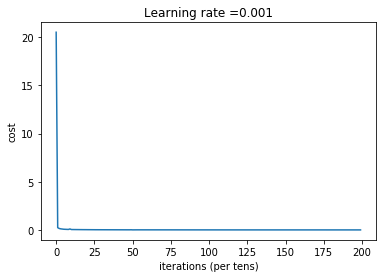

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 1.0


In [73]:
layer_h = [200, 200, 200, 200, 100, 50]
X_nn = np.array(prepare_mat_test(X))
y_lat_nn = np.array(prepare_ground_truth_test(ground_truth_lat))
y_lng_nn = np.array(prepare_ground_truth_test(ground_truth_lng))
y_nn = np.array([y_lat_nn, y_lng_nn])[:,:,0].T
X_train, X_test, y_train, y_test = train_test_split(X_nn, y_nn, test_size=0.1)
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T

parameters = model(X_train, y_train, X_test, y_test, learning_rate = 0.001, layer_h=layer_h, 
      num_epochs = 1000, minibatch_size = 32, print_cost = True)

In [77]:
nb_layers = len(layer_h) + 2
y_pred_test = predict(X_test, parameters, nb_layers)
y_pred_lat_test = y_pred_test[0,:]
y_pred_lng_test = y_pred_test[1,:]
y_lat_test = y_test[0,:]
y_lng_test = y_test[1,:]
err_vec_dev = Eval_geoloc(y_lat_test , y_lng_test, y_pred_lat_test, y_pred_lng_test)
print("Neural network Score 80 percentile =", np.percentile(err_vec, 80))

Neural network Score 80 percentile = 8866.187901132887


## Improving model: Grid search

In [78]:
grid_n_estimators = [50, 100, 300]
grid_max_depth = [10,20]

list_err_perc80_train = []
list_err_perc80_test = []
list_err_max_depth = []

for n_estimators in grid_n_estimators:
    for max_depth in grid_max_depth:   
        params={'max_depth':max_depth,'n_estimators':n_estimators}
        err_vec_train, err_vec_test = model_eval(X, list_folds_mask, y_lat, y_lng, model_fit_rf, params)
        err_mean_train, err_mean_test, err_perc80_train, err_perc80_test = calc_err(err_vec_train, err_vec_test)

        list_err_perc80_train.append(err_perc80_train)
        list_err_perc80_test.append(err_perc80_test)
    list_err_perc80_train = []
    list_err_perc80_test = []
    list_err_max_depth.append([list_err_perc80_train,list_err_perc80_test])

Compute fold 0/113 , temps restant 6.287047028541565 minutes
Compute fold 20/113 , temps restant 5.2304656134711385 minutes
Compute fold 40/113 , temps restant 4.076977917043174 minutes
Compute fold 60/113 , temps restant 2.971888404596048 minutes
Compute fold 80/113 , temps restant 1.8706818771950995 minutes
Compute fold 100/113 , temps restant 0.7719994331743854 minutes
err_mean_train = 1961.599709375709
err_mean_test = 3597.4010893889485
err_perc80_train = 2880.2193523299775
err_perc80_test = 4982.834984279655
Compute fold 0/113 , temps restant 10.478504729270934 minutes
Compute fold 20/113 , temps restant 8.743193498111909 minutes
Compute fold 40/113 , temps restant 6.878691001830063 minutes
Compute fold 60/113 , temps restant 5.011450361814656 minutes
Compute fold 80/113 , temps restant 3.155846866560572 minutes
Compute fold 100/113 , temps restant 1.2982885169510803 minutes
err_mean_train = 990.7510554227515
err_mean_test = 3414.840063712209
err_perc80_train = 1415.645454055013
e

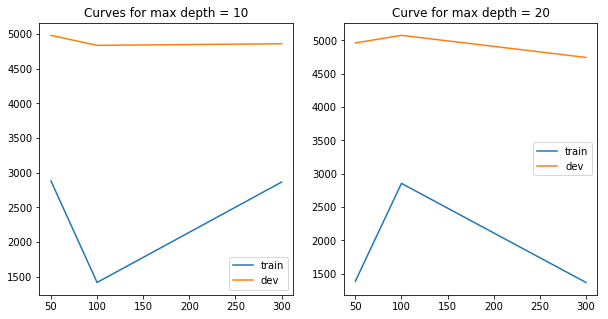

In [88]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(grid_n_estimators, list_err_max_depth[0][0], label="train")
plt.plot(grid_n_estimators, list_err_max_depth[0][1], label="dev")
plt.legend()
plt.title("Curves for max depth = " + str(grid_max_depth[0]))
plt.subplot(122)
plt.plot(grid_n_estimators, list_err_max_depth[1][0], label="train")
plt.plot(grid_n_estimators, list_err_max_depth[1][1], label="dev")
plt.title("Curve for max depth = " + str(grid_max_depth[1]))
plt.legend()

## Train model before submitting

In [91]:
best_max_depth = 20
best_n_estimators = 300
params = {'max_depth':best_max_depth,'n_estimators':best_n_estimators}
X = prepare_mat_test(df_feat_v2)
y_lat = prepare_ground_truth_test(ground_truth_lat)
y_lng = prepare_ground_truth_test(ground_truth_lng)
model_lat, model_lng = model_fit_rf(X, y_lat, y_lng, 0, 0, 0, params=params)

C:\Users\Thibault\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Thibault\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


# Submit

In [99]:
df_mess_test = pd.read_csv('Files/mess_test_list.csv') # test set
df_mess_test.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573be2503e952e191262c351,3578,116539.0,2.0,-111.0,1.463542e+12,39.728651,-105.163032
1,573c05f83e952e1912758013,2617,472504.0,0.0,-136.0,1.463551e+12,39.779908,-105.062479
2,573c05f83e952e1912758013,3556,472504.0,0.0,-127.0,1.463551e+12,39.780658,-105.053676
3,573c05f83e952e1912758013,3578,472504.0,0.0,-129.0,1.463551e+12,39.728651,-105.163032
4,573c05f83e952e1912758013,4058,472504.0,0.0,-105.0,1.463551e+12,39.783211,-105.088747


In [106]:
X_test = prepare_mat_test(feat_mat_const(df_mess_test,  nb_max_base=5))
X_test.head()

,bs_lat0,bs_lng0,nseq0,rssi0,bs_lat1,bs_lng1,nseq1,rssi1,bs_lat2,bs_lng2,nseq2,rssi2,bs_lat3,bs_lng3,nseq3,rssi3,bs_lat4,bs_lng4,nseq4,rssi4
0,39.728651,-105.163032,2.0,-111.0,39.728651,-105.163032,2.0,-111.0,39.728651,-105.163032,2.0,-111.0,39.728651,-105.163032,2.0,-111.0,39.728651,-105.163032,2.0,-111.0
1,39.779908,-105.062479,0.0,-136.0,39.780658,-105.053676,0.0,-127.0,39.728651,-105.163032,0.0,-129.0,39.783211,-105.088747,0.0,-105.0,39.782113,-105.072701,0.0,-117.0
2,39.779908,-105.062479,0.0,-136.0,39.780658,-105.053676,0.0,-127.0,39.728651,-105.163032,0.0,-129.0,39.783211,-105.088747,0.0,-105.0,39.782113,-105.072701,0.0,-117.0
3,39.779908,-105.062479,0.0,-136.0,39.780658,-105.053676,0.0,-127.0,39.728651,-105.163032,0.0,-129.0,39.783211,-105.088747,0.0,-105.0,39.782113,-105.072701,0.0,-117.0
4,39.779908,-105.062479,0.0,-136.0,39.780658,-105.053676,0.0,-127.0,39.728651,-105.163032,0.0,-129.0,39.783211,-105.088747,0.0,-105.0,39.782113,-105.072701,0.0,-117.0


In [107]:
y_pred_lat, y_pred_lng = model_predict(X_test, model_lat, model_lng)

In [109]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res['messid'] = df_mess_test['messid']
test_res.to_csv('Files/pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng,messid
0,39.758897,-105.005310,573be2503e952e191262c351
1,39.783738,-105.062346,573c05f83e952e1912758013
2,39.783738,-105.062346,573c05f83e952e1912758013
3,39.783738,-105.062346,573c05f83e952e1912758013
4,39.783738,-105.062346,573c05f83e952e1912758013
